# Figure Creator

In [1]:
import time
import json  # for checkpointing
import csv

from collections import Counter

from pathlib import Path

import numpy as np
# import scipy.sparse
# import torch
# import torch.nn.functional as F
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from tqdm.notebook import trange, tqdm

import pandas as pd

# import datetime

# import os
# from dotenv import load_dotenv, find_dotenv

from timeit import default_timer as timer

# load_dotenv(find_dotenv('config.env'))

# torch.cuda.current_device()
# torch.cuda.device(0)
# torch.cuda.device_count()
# torch.cuda.get_device_name(0)
# torch.cuda.is_available()

# import sklearn
# import sklearn.metrics
import seaborn as sns

In [2]:
diverging_palette_dark = sns.diverging_palette(250, 15, s=75, l=40, n=2, center="dark")
diverging_palette_light = sns.diverging_palette(240, 10, n=2, center="light")
diverging_palette_heatmap = sns.color_palette("icefire", as_cmap=True)

display(diverging_palette_dark)
display(diverging_palette_light)
display(diverging_palette_heatmap)

[(0.20651240887022015, 0.3755393698154809, 0.5856904756194529),
 (0.6565296443848212, 0.21867290090002556, 0.1744737357010414)]

[(0.2564697186166857, 0.4871591358142198, 0.657003695890986),
 (0.8545371341681446, 0.22957019267094914, 0.2762321841840895)]

In [3]:
def seconds_to_hhmmss(s):
    seconds = s
    minutes = seconds // 60
    hours = minutes // 60
    return "%02d:%02d:%02d" % (hours, minutes % 60, seconds % 60)

# Selected Model Loading

In [43]:
model_paths = {
#     'FFO-POOL':             Path('model_checkpoints/FFO-POOL-2021-05-07'),
    'MHA-1':           Path('model_checkpoints/MHA-1-POOL-2021-05-05'),
    'MHA-11':          Path('model_checkpoints/MHA-11-POOL-2021-05-06'),
    'MHA-34-NEW':          Path('model_checkpoints/MHA-34-POOL-NEW-2021-05-11'),
    'MHA-34':          Path('model_checkpoints/MHA-34-POOL-2021-05-05'),
    'MHA-34-B': Path('model_checkpoints/MHA-34-POOL-BALANCED-2021-05-08'),
#     'MHA-34-DISCARDS':      Path('model_checkpoints/MHA-34-DISCARDS-2021-05-07')
}

for name, path in model_paths.items():
    print(name)
    assert path.exists()

MHA-1
MHA-11
MHA-34-NEW
MHA-34
MHA-34-B


# Model Training/Validation Results Table

In [44]:
df_summaries = []

for name, path in model_paths.items():
    temp_df = pd.read_csv(path / 'summary.csv')
    temp_df['model'] = name

    
    df_summaries.append(temp_df)

df = pd.concat(df_summaries)
df

,epoch,train_loss,train_acc,train_average_valid_weight_sum,train_average_weight_per_valid_class,train_average_weight_per_invalid_class,val_loss,val_acc,val_average_valid_weight_sum,val_average_weight_per_valid_class,val_average_weight_per_invalid_class,time_elapsed,model
0,0,1.792813,0.424605,0.859065,0.086939,0.005956,1.189744,0.569893,0.992804,0.098374,0.000303,01:16:49,MHA-1
1,1,1.122307,0.597942,0.994509,0.101189,0.000230,1.051898,0.615344,0.995297,0.098632,0.000199,01:16:58,MHA-1
2,2,1.024073,0.629783,0.996134,0.101363,0.000163,0.982405,0.640892,0.995539,0.098668,0.000190,01:16:24,MHA-1
3,3,0.973225,0.646617,0.996774,0.101432,0.000136,0.943771,0.652576,0.997754,0.098894,0.000096,01:16:47,MHA-1
4,4,0.942240,0.656764,0.997163,0.101474,0.000120,0.945748,0.651079,0.997523,0.098869,0.000105,01:17:06,MHA-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,10,0.854571,0.685011,0.998009,0.101565,0.000085,0.909110,0.665731,0.997805,0.101397,0.000093,01:12:51,MHA-34-B
11,11,0.845385,0.687981,0.998077,0.101573,0.000082,0.911587,0.666711,0.998463,0.101464,0.000065,01:12:47,MHA-34-B
12,12,0.836801,0.690819,0.998130,0.101578,0.000080,0.915948,0.667006,0.998932,0.101513,0.000045,01:12:54,MHA-34-B
13,13,0.828671,0.693457,0.998180,0.101584,0.000077,0.906386,0.666430,0.997252,0.101344,0.000117,01:12:49,MHA-34-B


## Model Summary Table

In [45]:
temp_df = df[['model',
              'epoch', 
              'train_loss',
              'train_acc',
              'val_loss',
              'val_acc',
              'time_elapsed']].set_index(['model', 'epoch'])

# Get Average Time/Epoch
temp_df['time_elapsed'] = pd.to_timedelta(temp_df['time_elapsed'])
avg_time = temp_df.groupby('model')['time_elapsed'].mean(numeric_only=False)
avg_time = avg_time.dt.seconds.apply(seconds_to_hhmmss)

# Get Model rows with lowest val_loss
new = temp_df.loc[temp_df.groupby('model')['val_loss'].idxmin()]
new = new.drop(columns='time_elapsed')
new = new.reset_index().set_index('model')

# Merge calculated average time
new['avg_time_per_epoch'] = avg_time
new = new.reset_index()  # Makes index printing leveled with other columns
new

,model,epoch,train_loss,train_acc,val_loss,val_acc,avg_time_per_epoch
0,MHA-1,13,0.828671,0.693457,0.889034,0.668738,01:16:56
1,MHA-11,14,0.822897,0.695564,0.886992,0.668891,01:16:26
2,MHA-34,11,0.844935,0.688165,0.880565,0.672475,01:14:18
3,MHA-34-B,14,0.821033,0.696116,0.906012,0.667339,01:13:16
4,MHA-34-NEW,13,0.828671,0.693457,0.889034,0.668738,01:13:15


In [46]:
lstr = new.to_latex(index=False,
                    index_names=False, 
                    float_format="%.3f", 
                    bold_rows=True,
                   )

print(lstr)

\begin{tabular}{lrrrrrl}
\toprule
      model &  epoch &  train\_loss &  train\_acc &  val\_loss &  val\_acc & avg\_time\_per\_epoch \\
\midrule
      MHA-1 &     13 &       0.829 &      0.693 &     0.889 &    0.669 &           01:16:56 \\
     MHA-11 &     14 &       0.823 &      0.696 &     0.887 &    0.669 &           01:16:26 \\
     MHA-34 &     11 &       0.845 &      0.688 &     0.881 &    0.672 &           01:14:18 \\
   MHA-34-B &     14 &       0.821 &      0.696 &     0.906 &    0.667 &           01:13:16 \\
 MHA-34-NEW &     13 &       0.829 &      0.693 &     0.889 &    0.669 &           01:13:15 \\
\bottomrule
\end{tabular}



# Model Graph

In [47]:
# sns.set_style("ticks")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# sns.set_style("whitegrid")
# sns.set_style("darkgrid")

# sns.set_palette('bright')

### Non-Attention-Based Model - TRAINING VS VALIDATION

In [48]:
'FFO-POOL' in df.model.values

False

In [49]:
if 'FFO-POOL' in df.model.values:
    
    title_fontsize = 17
    ticks_fontsize = 13
    label_fontsize = 15
    legend_fontsize = 13
    figsize = (15, 4)
    
    # ACCURACY
    figure = plt.figure(figsize=figsize)
    ax = plt.axes()

    plt.plot(df[df.model == 'FFO-POOL']['train_acc'][0:20], label='Training')
    plt.plot(df[df.model == 'FFO-POOL']['val_acc'][0:20], label='Validation')

    plt.title('Non-Attention-Based Model\nAccuracy', fontsize=title_fontsize)
    plt.xlabel('Epochs', fontsize=label_fontsize)
    plt.ylabel('Accuracy', fontsize=label_fontsize)
    plt.legend(fontsize=legend_fontsize)

    step = range(20)
    plt.xticks(step, fontsize=ticks_fontsize)
    plt.yticks(np.arange(0.0, 1.0, 0.1), fontsize=ticks_fontsize)


    plt.savefig(Path('figures') / "FFO_train_val_acc.png", bbox_inches='tight')

    plt.show()
    
    # LOSS
    figure = plt.figure(figsize=figsize)
    ax = plt.axes()

    plt.plot(df[df.model == 'FFO-POOL']['train_loss'][0:20], label='Training')
    plt.plot(df[df.model == 'FFO-POOL']['val_loss'][0:20], label='Validation')

    plt.title('Non-Attention-Based Model\nLoss', fontsize=title_fontsize)
    plt.xlabel('Epochs', fontsize=label_fontsize)
    plt.ylabel('Loss', fontsize=label_fontsize)
    plt.legend(fontsize=legend_fontsize)

    step = range(20)
    plt.xticks(step, fontsize=ticks_fontsize)
    plt.yticks(fontsize=ticks_fontsize)

    plt.savefig(Path('figures') / "FFO_train_val_loss.png", bbox_inches='tight')

    plt.show()

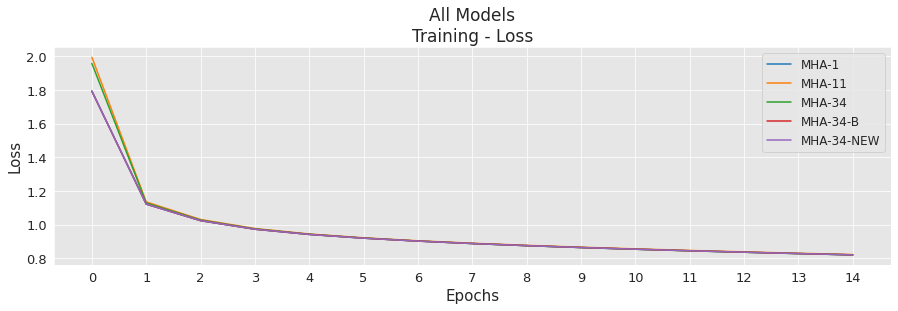

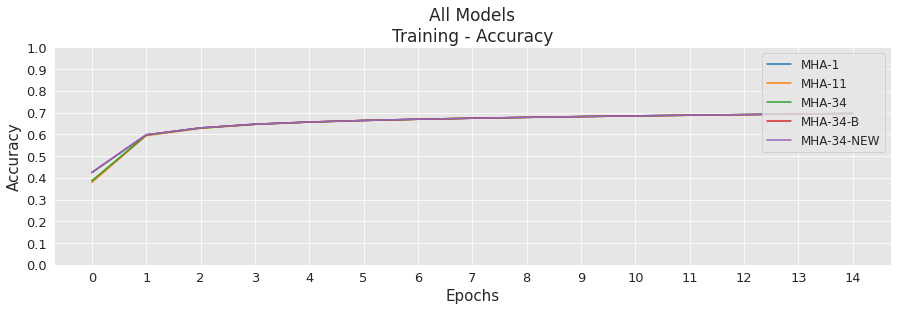

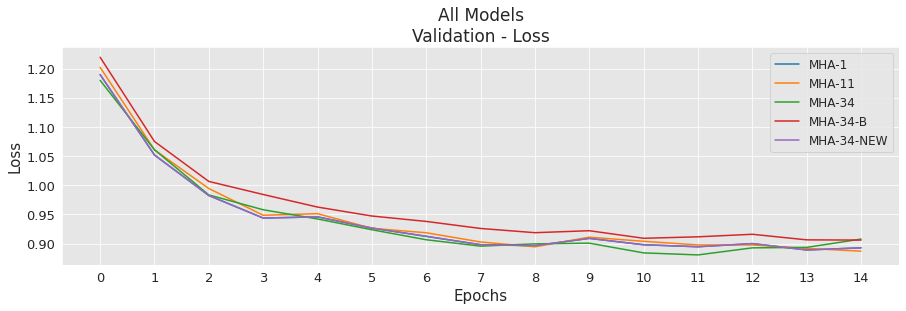

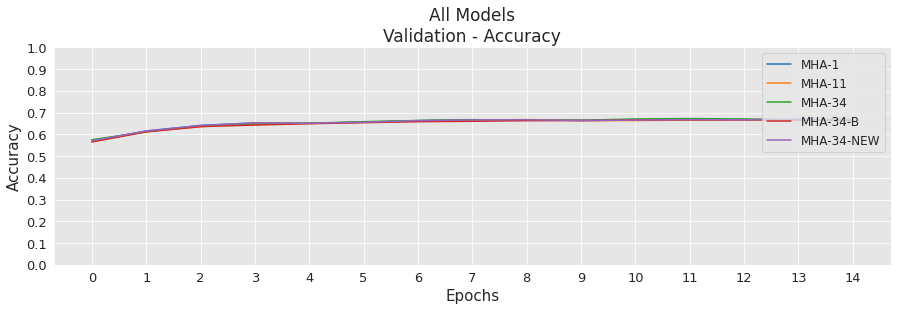

In [50]:
def plot_summary(summaries: pd.DataFrame, column_name: str, title: str, y_label: str, epochs=15):
    
    title_fontsize = 17
    ticks_fontsize = 13
    label_fontsize = 15
    legend_fontsize = 12
    figsize = (15, 4)

    figure = plt.figure(figsize=figsize)
    ax = plt.axes()
    
    
    for summary in [y for x, y in summaries.groupby('model', as_index=False)]:
        plt.plot(summary[column_name][0:epochs], label=summary['model'][0])

    plt.title('All Models\n' + title, fontsize=title_fontsize)
    plt.xlabel('Epochs', fontsize=label_fontsize)
    plt.ylabel(y_label,  fontsize=label_fontsize)
    plt.legend(loc='upper right', fontsize=legend_fontsize)
    
    step = range(epochs)
    plt.xticks(step, fontsize=ticks_fontsize)
    
    if y_label == 'Accuracy':
        plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=ticks_fontsize)
    else:
        plt.yticks(fontsize=ticks_fontsize)

    file_name = title.replace(' ', '').replace('-', '_').lower()
    plt.savefig(Path('figures') / f'ALL_{file_name}.png', bbox_inches='tight')
    
    plt.show()

# filtered_df = df[df.model != 'FFO-POOL']  # Filtering away certain models
filtered_df = df

# Training
plot_summary(summaries=filtered_df,
             column_name='train_loss', 
             title='Training - Loss', 
             y_label='Loss')

plot_summary(summaries=filtered_df,
             column_name='train_acc', 
             title='Training - Accuracy', 
             y_label='Accuracy')

# Validation
plot_summary(summaries=filtered_df,
             column_name='val_loss', 
             title='Validation - Loss', 
             y_label='Loss')

plot_summary(summaries=filtered_df,
             column_name='val_acc', 
             title='Validation - Accuracy', 
             y_label='Accuracy')

# Valid Class Heatmaps
Copied from the original `model.ipynb`

In [35]:
def graph_heatmap(df, model_name: str, mode: int, epoch: int):
    
    filtered_df = df[(df['mode'] == mode) & (df['epoch'] == epoch)]
    
    assert len(filtered_df) == 14, f"NOT ENOUGH ROWS FOR HEATMAP! EXPECTED 14, got {len(filtered_df)}"
    
    plt.figure(figsize=(19, 6))
    ax = sns.heatmap(filtered_df.drop(columns=['mode', 'epoch', 'n_valid']), 
                     annot=True, 
                     fmt=".1f", 
                     cmap="icefire",  # icefire, coolwarm
                     center=0.5,
#                      linewidths=.2,
#                      linecolor='black',
                     annot_kws={"fontsize":12},
                     vmin=0.0, vmax=1.0,
#                      square=True,
                     xticklabels=range(0, 34),
                     yticklabels=range(1, 15),
                     cbar=False,
                     cbar_kws=dict(shrink=0.4, label='Average propability', ticks=np.arange(0.0, 1.2, 0.2))
                )

#     ax.vlines(range(1, 34), -1, 15, linewidth=2, color="black")

    ax.hlines(range(1, 15), -0.2, 34, linewidth=3, color="white")
    
    mode = 'Training' if mode == 0 else 'Validation'
    plt.title(f"Valid class occurrence heatmap\n{model_name} - {mode} - Epoch {epoch}", fontsize=18)
    
    plt.xlabel('Prediction priority', fontsize=16)
    plt.ylabel('Number of valid classes', fontsize=16)
    
    plt.yticks(rotation=0, fontsize=14, va="center")
    plt.xticks(fontsize=14)
    
    plt.savefig(Path('figures') / f'{model_name}_heatmap_{mode.lower()}_epoch-{epoch}.png', bbox_inches='tight')

    plt.show()

Epoch with lowest val_loss: 11


,mode,epoch,n_valid,h_0,h_1,h_2,h_3,h_4,h_5,h_6,...,h_24,h_25,h_26,h_27,h_28,h_29,h_30,h_31,h_32,h_33
0,0,0,1,0.666667,0.000000,0.000000,0.000000,0.020833,0.041667,0.020833,...,0.041667,0.000000,0.000000,0.000000,0.020833,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0,2,0.773547,0.738639,0.030465,0.025387,0.020183,0.020183,0.018660,...,0.011424,0.010536,0.010916,0.012821,0.014725,0.012694,0.013963,0.012821,0.011043,0.009139
2,0,0,3,0.779802,0.754052,0.654908,0.084366,0.051344,0.039840,0.035600,...,0.016589,0.016406,0.016772,0.021309,0.021222,0.019925,0.018244,0.016624,0.013733,0.012775
3,0,0,4,0.795711,0.777894,0.748297,0.638747,0.121462,0.074272,0.060015,...,0.019994,0.019518,0.018876,0.019630,0.018879,0.018303,0.016662,0.016133,0.013102,0.012002
4,0,0,5,0.805097,0.788758,0.766503,0.711444,0.560473,0.179444,0.112172,...,0.025521,0.025225,0.024824,0.027325,0.026509,0.025354,0.023321,0.021545,0.017565,0.015796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,1,14,10,0.999958,0.999324,0.997590,0.991496,0.975896,0.949726,0.906917,...,0.012343,0.010322,0.008421,0.007012,0.005338,0.004447,0.002834,0.002036,0.001156,0.000472
416,1,14,11,0.999986,0.999820,0.998803,0.995732,0.986197,0.963532,0.922475,...,0.021259,0.017652,0.014448,0.011750,0.009386,0.007104,0.005103,0.003177,0.001809,0.000702
417,1,14,12,0.999992,0.999812,0.999099,0.995700,0.984578,0.959564,0.915750,...,0.044160,0.037176,0.032035,0.026737,0.021888,0.016488,0.012279,0.008624,0.005065,0.001896
418,1,14,13,0.999987,0.999679,0.997961,0.993906,0.980008,0.951087,0.906073,...,0.072555,0.062797,0.054415,0.045624,0.037896,0.030163,0.022961,0.016003,0.009375,0.003681


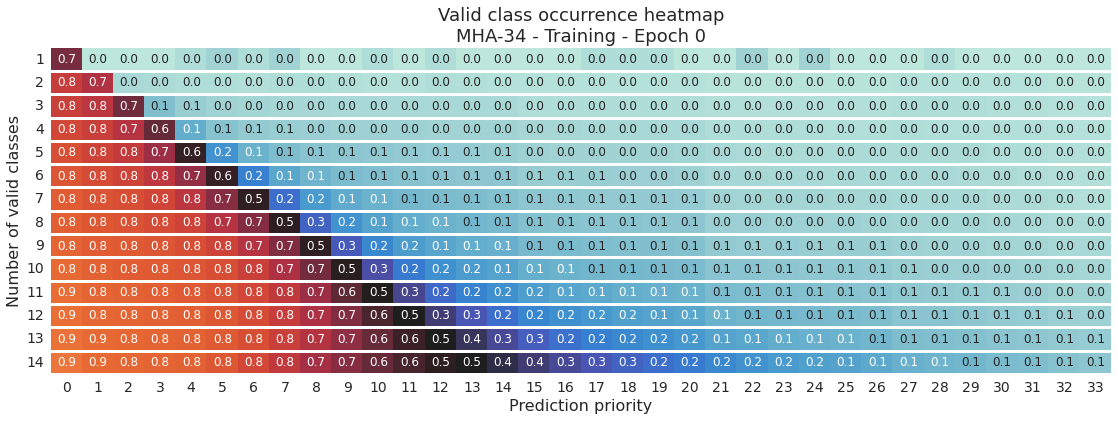

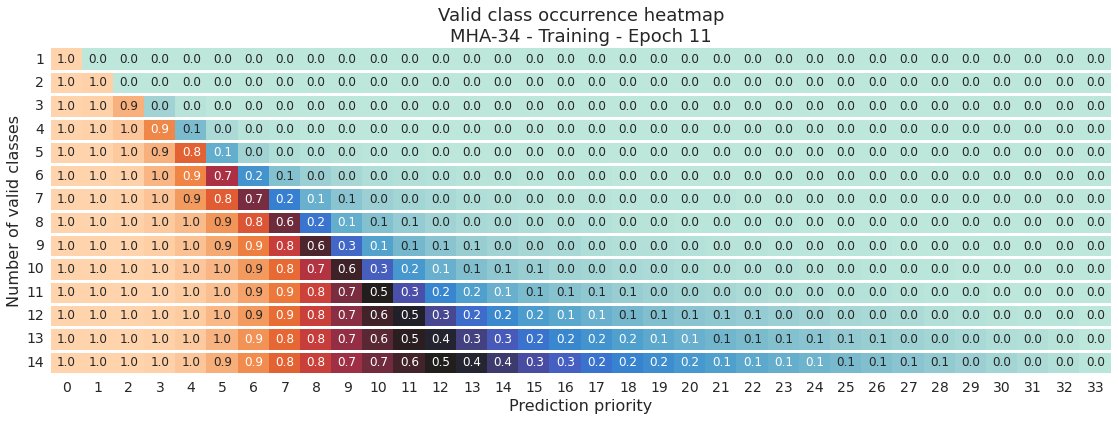

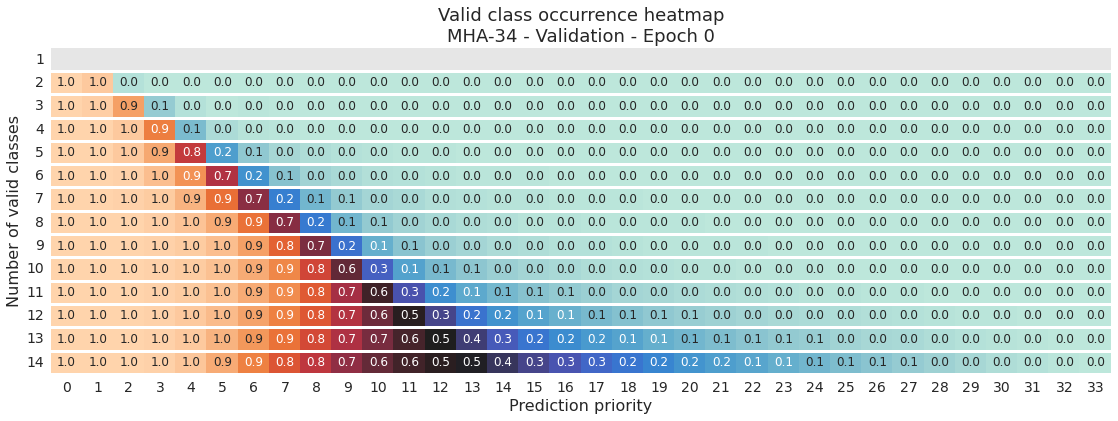

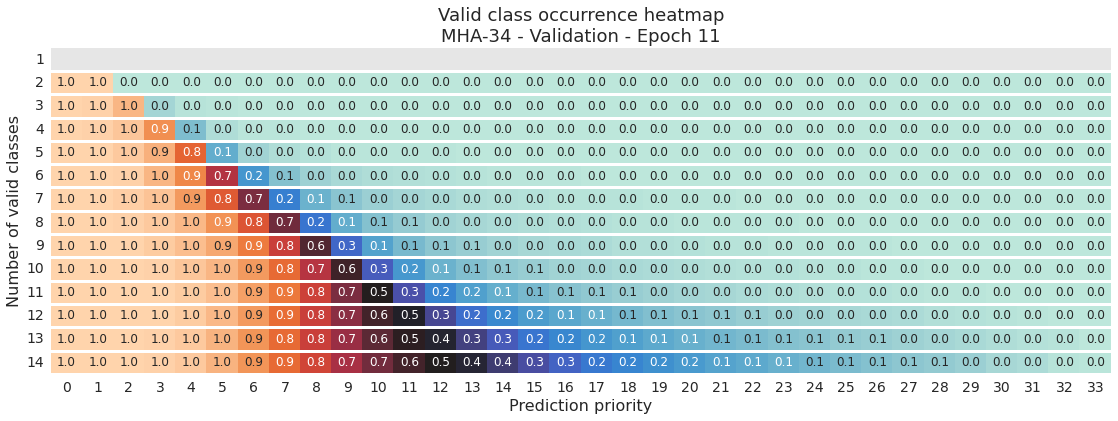

In [36]:
model_name = 'MHA-34'  # SWITCH MODEL HERE

heatmap_df = pd.read_csv(model_paths[model_name] / 'heatmap.csv')
heatmap_df = heatmap_df.astype({'mode': 'int32', 'epoch': 'int32', 'n_valid': 'int32'})

best_epoch = new[new.model == model_name]['epoch'].values[0]

print("Epoch with lowest val_loss:", best_epoch)
display(heatmap_df)

graph_heatmap(heatmap_df, model_name, 0, 0)
graph_heatmap(heatmap_df, model_name, 0, best_epoch)  # LOAD CORRECT EPOCH!

graph_heatmap(heatmap_df, model_name, 1, 0)
graph_heatmap(heatmap_df, model_name, 1, best_epoch)  # LOAD CORRECT EPOCH!

# Inversion
Originally from `model.ipynb`

In [37]:
model_name = 'MHA-34'  # SWITCH MODEL HERE

best_epoch = new[new.model == model_name]['epoch'].values[0]

inversion_count_df = pd.read_csv(model_paths[model_name] / 'inversions_counts.csv')  # Needed for next step
inversion_count_df = inversion_count_df.iloc[1:].reset_index(drop=True)

inversion_stats_df = pd.read_csv(model_paths[model_name] / 'inversions.csv')
inversion_stats_df = inversion_stats_df.fillna(-1)  # Replaces NAN with -1
inversion_stats_df = inversion_stats_df.astype({
    'median': 'Int64',
    'n_valid': int,
})

display(inversion_count_df)
display(inversion_stats_df)

,n_valid_classes,training_count,validation_count,testing_count
0,1,48,0,0
1,2,7878,446,280
2,3,114833,4220,4366
3,4,319352,13025,12969
4,5,462327,18959,18675
5,6,972440,39667,38749
6,7,1581672,67552,64995
7,8,2174647,91694,90478
8,9,3856788,168158,167907
9,10,5592282,264689,263161


,mode,epoch,n_valid,min,max,mean,median
0,0,0,1,0.0,28.0,4.791667,0
1,0,0,2,0.0,63.0,7.142930,0
2,0,0,3,0.0,93.0,10.806240,0
3,0,0,4,0.0,120.0,12.610521,0
4,0,0,5,0.0,143.0,16.118325,1
...,...,...,...,...,...,...,...
415,1,14,10,0.0,108.0,6.465879,3
416,1,14,11,0.0,120.0,8.807247,5
417,1,14,12,0.0,141.0,13.820873,10
418,1,14,13,0.0,138.0,18.937884,15


# INVERSION LATEX

## TODO: Make it create the validation table as well!

In [38]:
def inversion_latex(mode='training'):
    
    selected_mode = 0 if mode == 'training' else 1
    
    # Initial Values
    inversion_training_0 = inversion_stats_df[
        (inversion_stats_df['mode'] == selected_mode) &
        (inversion_stats_df['epoch'] == 0)
    ][['n_valid', 'max','mean', 'median']]

    # Best Values
    inversion_training_1 = inversion_stats_df[
        (inversion_stats_df['mode'] == selected_mode) &
        (inversion_stats_df['epoch'] == best_epoch)
    ][['n_valid', 'max', 'mean', 'median']]
    inversion_training_1 = inversion_training_1.rename(columns={'max': 'max_2', 'median': 'median_2', 'mean': 'mean_2'})
    
    # Reset index or else we cannot merge correctly
    inversion_training_0.reset_index(drop=True, inplace=True)
    inversion_training_1.reset_index(drop=True, inplace=True)

    # Merge above values with Count Table
    column_name = 'training_count' if selected_mode == 0 else 'validation_count'
    xx = pd.concat([inversion_training_0, inversion_count_df[column_name]], axis=1)
    xx = pd.merge(xx,  inversion_training_1)
    xx = xx[['n_valid',column_name, 'max', 'max_2', 'mean', 'mean_2', 'median', 'median_2']]
        
    xx = xx.replace(-1, pd.NA)
    
    # Make it Nullable
    xx = xx.astype({
        'n_valid'  : 'Int64',
        'max'      : 'Int64',
        'max_2'    : 'Int64',
        'mean'     : 'Float64',
        'mean_2'   : 'Float64',
        'median'   : 'Int64',
        'median_2' : 'Int64',
    })
    


#     xx['max'] = xx['max'].astype('Int64')  # Oddly changes to float in previous step
#     xx['median'] = xx['median'].astype('Int64')  # Oddly changes to float in previous step


    latex_inversion_table = xx.to_latex(index=False, 
                                        index_names=False, 
                                        float_format="%.2f", 
                                        na_rep='-'
#                                         bold_rows=True,
#                                         header=['Number of valid classes', 'Median inversions', 'Mean number of inversions']
                                       )

    print(latex_inversion_table.replace('<NA>', '   -'))

print('CHANGE EPOCH TO:', best_epoch)
print('ONLY COPY VALUES, COLUMN HEADERS IS WRONG')
print("TRAINING TABLE:")
inversion_latex('training')
print('ONLY COPY VALUES, COLUMN HEADERS IS WRONG')
print("VALIDATION TABLE:")
inversion_latex('validation')

CHANGE EPOCH TO: 11
ONLY COPY VALUES, COLUMN HEADERS IS WRONG
TRAINING TABLE:
\begin{tabular}{rrrrrrrr}
\toprule
 n\_valid &  training\_count &  max &  max\_2 &  mean &  mean\_2 &  median &  median\_2 \\
\midrule
       1 &              48 &   28 &      0 &  4.79 &    0.00 &       0 &         0 \\
       2 &            7878 &   63 &      6 &  7.14 &    0.01 &       0 &         0 \\
       3 &          114833 &   93 &     26 & 10.81 &    0.10 &       0 &         0 \\
       4 &          319352 &  120 &     32 & 12.61 &    0.28 &       0 &         0 \\
       5 &          462327 &  143 &     61 & 16.12 &    0.70 &       1 &         0 \\
       6 &          972440 &  168 &     72 & 18.15 &    1.75 &       2 &         0 \\
       7 &         1581672 &  185 &     81 & 20.07 &    2.88 &       2 &         0 \\
       8 &         2174647 &  204 &     97 & 22.98 &    3.28 &       3 &         1 \\
       9 &         3856788 &  221 &    120 & 25.23 &    4.57 &       4 &         1 \\
      10 &   

<Figure size 720x360 with 0 Axes>

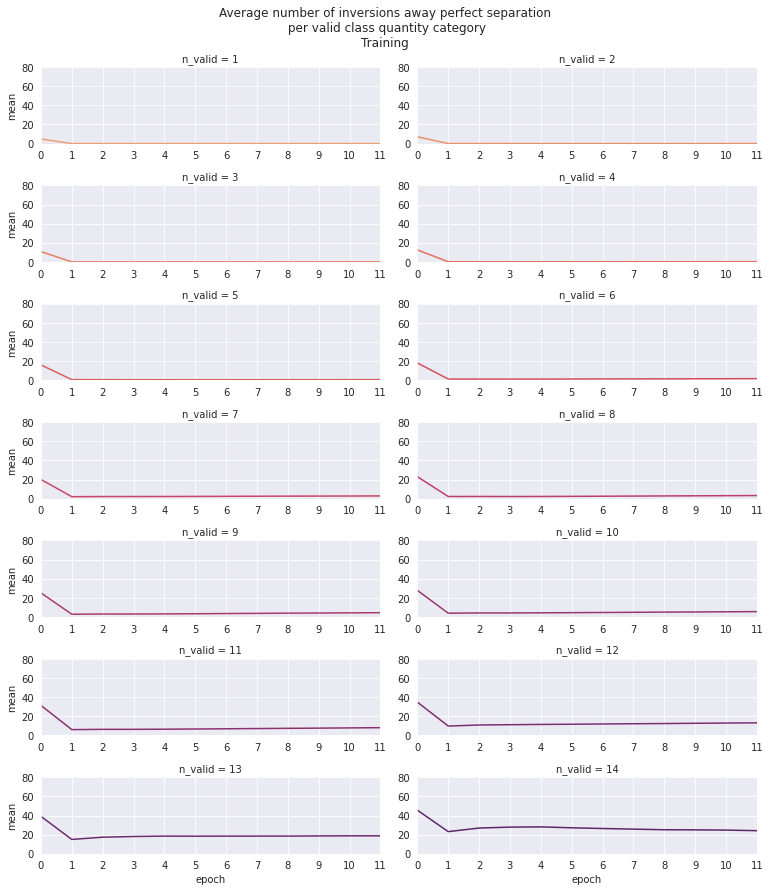

<Figure size 720x360 with 0 Axes>

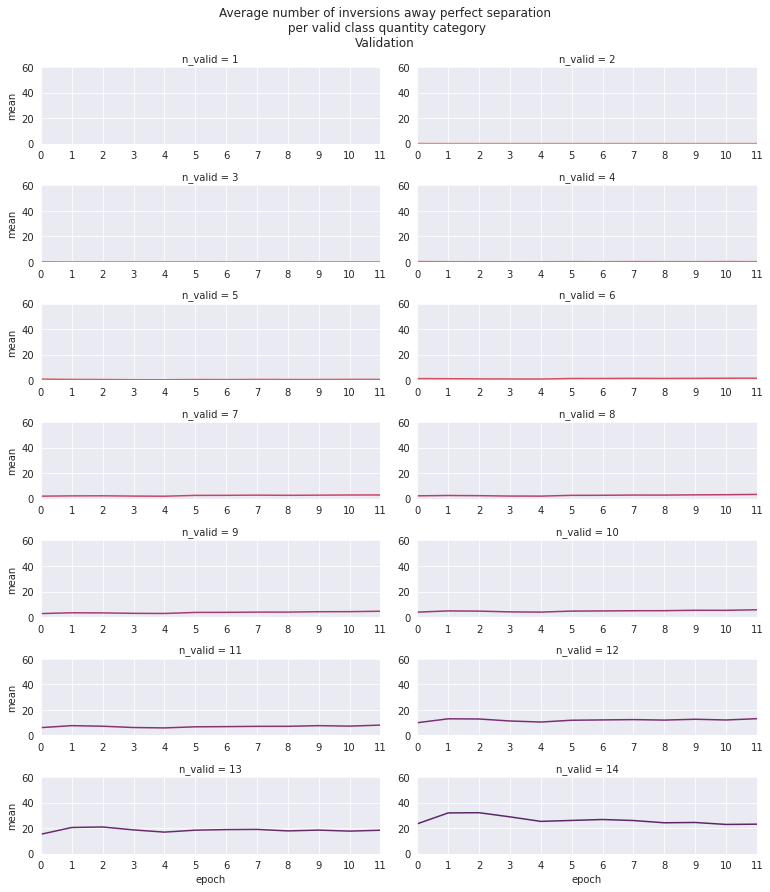

In [39]:
def graph_inversion_facetgrid(df, mode: int):
    
    sorted_df = df[(df['mode'] == mode)]
    
    sns.set_style("darkgrid")

    plt.figure(figsize=(10, 5))

    g = sns.FacetGrid(sorted_df, 
                      col="n_valid", 
                      height=1.8, 
                      aspect=3, 
                      col_wrap=2, 
                      sharex=False, 
                      sharey=False,
                      palette="flare",
                      hue='n_valid',
    #                   legend_out=True,
    #                   margin_titles=True
                     )

    g.set(
        xlim=(0, best_epoch), 
        ylim=(0, sorted_df['mean'].max()), 
        xticks=np.arange(0, best_epoch + 1, 1), 
        yticks=np.arange(0, sorted_df['mean'].max() + 40, 20)
    )

    g.fig.suptitle(f"Average number of inversions away perfect separation\n per valid class quantity category\n{'Training' if mode == 0 else 'Validation'}")

    g.map(sns.lineplot, 'epoch', 'mean')

    plt.show()
    
graph_inversion_facetgrid(inversion_stats_df, 0)
graph_inversion_facetgrid(inversion_stats_df, 1)

In [40]:
inversion_stats_df[(inversion_stats_df['mode'] == 1)]

,mode,epoch,n_valid,min,max,mean,median
14,1,0,1,-1.0,-1.0,-1.000000,-1
15,1,0,2,0.0,17.0,0.060538,0
16,1,0,3,0.0,23.0,0.169668,0
17,1,0,4,0.0,19.0,0.303800,0
18,1,0,5,0.0,38.0,0.953057,0
...,...,...,...,...,...,...,...
415,1,14,10,0.0,108.0,6.465879,3
416,1,14,11,0.0,120.0,8.807247,5
417,1,14,12,0.0,141.0,13.820873,10
418,1,14,13,0.0,138.0,18.937884,15


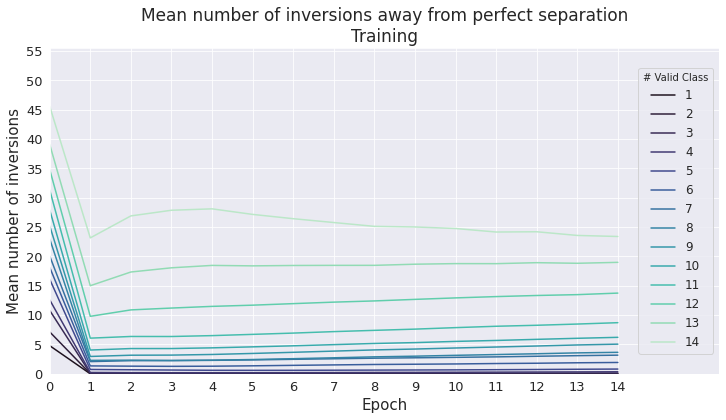

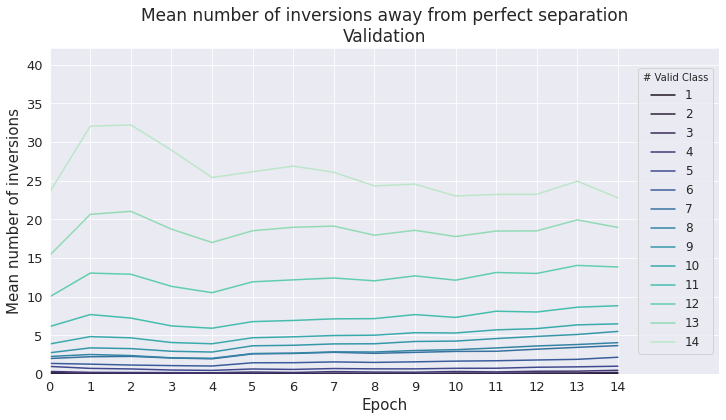

In [41]:
def create_inversion_lineplot(df, mode: int):
    
    title_fontsize = 17
    ticks_fontsize = 13
    label_fontsize = 15
    legend_fontsize = 12
    figsize = (12, 6)
    
    sorted_df = df[(df['mode'] == mode)]
#     sorted_df = sorted_df[(df['epoch'] <= best_epoch)]
    
    sns.set_style("darkgrid")

    plt.figure(figsize=figsize)

    ax = sns.lineplot(data=sorted_df, 
                 x='epoch', 
                 y='mean', 
                 hue='n_valid',
#                  style='n_valid',
    #              markers=True,
                 palette=sns.color_palette("mako", n_colors=14)
,
                )

#     ax.set(
# #         title=f"Average number of inversions away perfect separation per valid class quantity category\n{'Training' if mode == 0 else 'Validation'}",
# #         xlim=(0, sorted_df['epoch'].max() + 2), 
# #         ylim=(0, sorted_df['mean'].max() + 10), 
#     )
    
    #  per valid class quantity category
    plt.title(f"Mean number of inversions away from perfect separation\n{'Training' if mode == 0 else 'Validation'}",
              fontsize=title_fontsize)
    
    plt.ylabel('Mean number of inversions', fontsize=label_fontsize)
    plt.xlabel('Epoch', fontsize=label_fontsize)
    
    plt.xticks(np.arange(0, sorted_df['epoch'].max() + 1, 1),  fontsize=ticks_fontsize)
    plt.yticks(np.arange(0, sorted_df['mean'].max() + 10, 5), fontsize=ticks_fontsize)
    plt.xlim(0, sorted_df['epoch'].max() + 2.5)
    plt.ylim(0, sorted_df['mean'].max() + 10)
    
    plt.legend(title='# Valid Class', 
               loc='center right',
               fontsize=legend_fontsize)

    
    plt.savefig(Path('figures') / f"{model_name}_inversion_{'training' if mode == 0 else 'validation'}.png", bbox_inches='tight')
    
    plt.show()
    
create_inversion_lineplot(inversion_stats_df, 0)
create_inversion_lineplot(inversion_stats_df, 1)

# Valid / Invalid Prediction Propability Sum

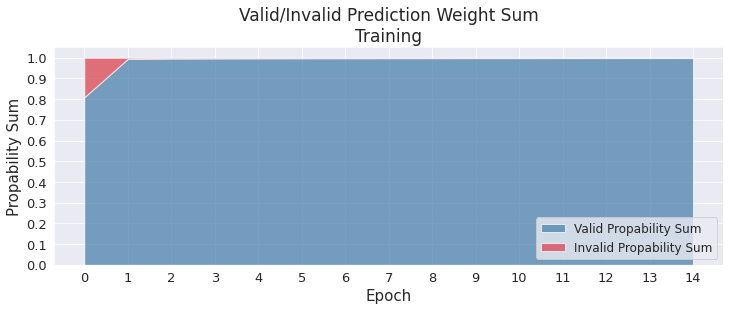

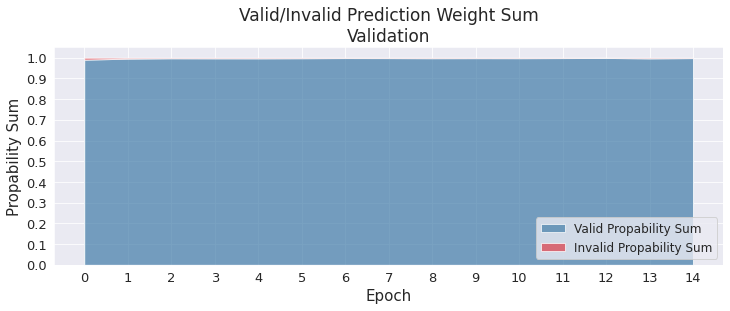

In [42]:
model_name = 'MHA-34'  # SWITCH MODEL HERE

# best_epoch = new[new.model == model_name]['epoch'].values[0]

summary = pd.read_csv(model_paths[model_name] / 'summary.csv')  # Needed for next step

def graph_weigh_sum_epochwise(weigh_sum_column, title, mode):
    
    title_fontsize = 17
    ticks_fontsize = 13
    label_fontsize = 15
    legend_fontsize = 12
    figsize = (12, 4)
    
    x = range(0, len(weigh_sum_column))
    y = [weigh_sum_column, (1 - weigh_sum_column)]

    figure = plt.figure(figsize=figsize)

    plt.stackplot(x, y, 
                  labels=['Valid Propability Sum', 'Invalid Propability Sum'], 
                  alpha=0.7,
                  colors=diverging_palette_light)
    
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=ticks_fontsize)
    plt.xticks(np.arange(0, len(weigh_sum_column), 1), fontsize=ticks_fontsize)

    plt.legend(loc='lower right', fontsize=legend_fontsize)

    plt.title(title, fontsize=title_fontsize)
    plt.xlabel('Epoch', fontsize=label_fontsize)
    plt.ylabel('Propability Sum', fontsize=label_fontsize)
    
    plt.savefig(Path('figures') / f"{model_name}_probability_sum_{'training' if mode == 0 else 'validation'}.png", bbox_inches='tight')

    plt.show()

graph_weigh_sum_epochwise(summary['train_average_valid_weight_sum'], "Valid/Invalid Prediction Weight Sum\nTraining", 0)
graph_weigh_sum_epochwise(summary['val_average_valid_weight_sum'], "Valid/Invalid Prediction Weight Sum\nValidation", 1)

# Best Discard Format [DEPRECATED?]

### TODO: LOAD CHOSEN MODEL

In [ ]:
df_pools_only = pd.read_csv('model_checkpoints/mha_pool_balanced_val_2021-04-30/summary.csv')
df_pools_meld = pd.read_csv('model_checkpoints/mha_pool_imbalanced_val_2021-05-01/summary.csv')

In [ ]:
figure = plt.figure(figsize=(16, 5))

plt.plot(df_pools_only['epoch'], df_pools_only['val_loss'], label='POOLS-ONLY Dataset')
plt.plot(df_pools_meld['epoch'], df_pools_meld['val_loss'], label='POOLS+MELDS Dataset')

plt.title('Discard Format Comparison: POOLS-ONLY vs. POOLS+MELDS\nValidation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.xticks(df1['epoch'])

plt.show()

In [ ]:
figure = plt.figure(figsize=(16, 5))

plt.plot(df_pools_only['epoch'], df_pools_only['val_acc'], label='POOLS-ONLY Dataset')
plt.plot(df_pools_meld['epoch'], df_pools_meld['val_acc'], label='POOLS+MELDS Dataset')

plt.title('Discard Format Comparison: POOLS-ONLY vs. POOLS+MELDS\nValidation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.xticks(df1['epoch'])

plt.show()